# Pairk - tutorial notebook

Pairk - quantifying the conservation of motifs within intrinsically disordered regions.

This notebook will go over the basics of how to use the pairk library using an example set of sequences (comes pre-installed with pairk).

## brief overview of pairk

Pairk can be divided into 2 parts:
1. `pairk_aln` - pairwise kmer alignment. Aligns each k-mer in a query sequence with each sequence in a set of homologs. The alignment is gapless and performed pairwise. For each k-mer in the query sequence, the result is a set of the best matching k-mers from each homolog. We call this set of k-mers a "pseudo-MSA". The k-mer alignment step can be performed via a scoring matrix (similar to a traditional alignment), or via ESM2 embeddings. These are explained in more detail below.
2. `pairk_conservation` - scores the conservation of the pseudo-MSAs via columnwise conservation scores.

# Step 1. pairk_aln

The basic input for step 1 is:
- `idr_dict_in` - a dictionary of IDR sequences, where the keys are the sequence ids and the values are the sequences. Includes the query sequence (the sequence to split into k-mers and align with the homologs).
- `query_id` - a query sequence id (the sequence to split into k-mers and align with the homologs). This id should be present in `idr_dict_in`.
- `k` - the length of the k-mers

These inputs can be generated many ways, and there are helper functions in the pairk library to help with this. For this example, we will use the example sequences that come with pairk.

## import pairk

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pairk

## load an example dataset

In [4]:
ex1 = pairk.example1

This example is imported as an object but it just holds the arguments that we need for `pairk_aln`:<br> 
- the IDR sequences in a dictionary - `ex1.idr_dict`<br>
- the query id - `ex1.query_id`<br>

In [5]:
for id,seq in ex1.idr_dict.items():
    print(id,seq)

9606_0:00294e TNLGTVNAAAPAQPSTGPKTGTTQPNGQIPQATHSVSAVLQEAQRHAETSKDKKPALGNHHDPAVPRAPHAPKSSLPPPPPVRRSSDTSGSPATPLKAKGTGGGGLPAPPDDFLPPPPPPPPLDDPELPPPPPDFMEPPPDFVPPPPPSYAGIAGSELPPPPPPPPAPAPAPVPDSARPPPAVAKRPPVPPKRQENPGHPGGAGGGEQDFMSDLMKALQKKRGNVS
9793_0:005123 TNVGTGNAATPAPPSTGLKTGTAQANGQIPQAAHSVSTVLNEADRQVDTPKDKKPALSNHDPGTPRAQHLPKSSLPPPPPVRRSSDTSSSPVMPAKGAAGGLPPLLDDSLPPPPPPPPLEDDELPPPPPDFDDAPPNFVPPPPPWDAGASLPPPPPPPPPALALAPEATKPSPVVAKRPPVPPKRQENPAPASGGGGGEQDFMSDLMKALQKKRGNVA
1706337_0:000fc7 TNLGTVNAAPPAPSSTGVKTGTTQANGQIPQAAHSMSTVLGEAQRQVETTKDKKSGLGSHDPGAPRAQTLPKSSLPPPPPVRRSSEVGCGSPGTSPKVKGAAAGFPAPPHDLLPPPPPPPPLEDDELPPPPPDFSDAPPDFVPPPPPPSFAGDAGSSLPPPPPPPALAPEAAKPTPVVVKRPPAPPKRQANPGPPGGGGGEQDFMSDLMKALQKKRSNMP
51337_0:001b5a TNLGTVNTATPAQPSTGFKTGSSQPNGQIPQTIPSVSAGLQEAQRHETIKDKKPSLSSTEPGAPRDPPGARSSLPPPPPPVRRSSDTCARAASPFPAPPDDLPPPPPPPPLEDPAMLPPPPALPEPPPDCVPPPPPPPGPGPQPARPSPGAGRRPPVPPKRQENPGLPSAGAGGEQDFMSDLMKALQKRGHMP
9568_0:004ae1 TNLGTVNAAAPAQPSTGPINGTAQPNGQMPQAAHSVSAVLQEAQRHAETSKVKPARPINGTAQPN

In [6]:
print(ex1.query_id)

9606_0:00294e


## the scoring matrix method

These methods use a scoring matrix to score the query k-mer to homolog k-mer matches and select the best scoring match from each homolog.

There are 2 implementations of the scoring matrix method:
1. `pairk.pairk_alignment` - the original implementation. This is a bit slow because it does an exhaustive comparison of all k-mers in the query sequence with all k-mers in the homologs.
2. `pairk.pairk_alignment_needleman` - a faster implementation that uses the Needleman-Wunsch algorithm (as implemented in Biopython) to align the k-mers. This is faster and should yield the same results.


To specify the scoring matrix used, you can pass the name of the matrix to the `matrix_name` argument. <br>
To see the available matrices, use the `pairk.print_available_matrices()` function.


<font size="2">*Note*: These methods currently find the best scoring match from each homolog for each query k-mer. However, if there are multiple top-scoring matches, only one is returned. The `pairk.pairk_alignment` method could be modified to return all top-scoring matches if needed, however that is not currently implemented. This may be more difficult to implement for the `pairk.pairk_alignment_needleman` method, though it should still be possible since the Biopython method (`Bio.Align.PairwiseAligner.align`) returns many alignments. The relevant code files are i `pairk/backend/kmer_alignment/` if you want to try to implement this yourself.</font>

In [7]:
pairk.print_available_matrices()

biopython-builtin matrices (aligner compatible):
BENNER22
BENNER6
BENNER74
BLASTN
BLASTP
BLOSUM45
BLOSUM50
BLOSUM62
BLOSUM80
BLOSUM90
DAYHOFF
FENG
GENETIC
GONNET1992
HOXD70
JOHNSON
JONES
LEVIN
MCLACHLAN
MDM78
MEGABLAST
NUC.4.4
PAM250
PAM30
PAM70
RAO
RISLER
SCHNEIDER
STR
TRANS

other matrices:
BLOSUM62
EDSSMat50
grantham
grantham_similarity_norm
grantham_similarity_normx100_aligner_compatible


### `pairk.pairk_alignment` - slower of the two methods

In [8]:
aln_results = pairk.pairk_alignment(
    idr_dict_in=ex1.idr_dict, 
    query_id=ex1.query_id,
    k=5, 
    matrix_name="EDSSMat50"
)

#### `pairk_aln` results

The results are returned as a `PairkAln` object.<br>

The actual "alignments" are stored as matrices in the `PairkAln` object. The main matrices are:<br>
- orthokmer_matrix - the best matching k-mers from each homolog for each query k-mer<br>
- position_matrix - the positions of the best matching k-mers in the homologs<br>
- score_matrix - the scores of the best matching k-mers<br>

Each matrix is a pandas DataFrame where the index is the start position of the k-mer in the query sequence. The columns are the query k-mers + the homolog sequence ids.

In [9]:
type(aln_results)

pairk.backend.tools.pairwise_tools.PairkAln

In [10]:
pairk.PairkAln?

Init signature:
pairk.PairkAln(
    orthokmer_df: pandas.core.frame.DataFrame,
    pos_df: pandas.core.frame.DataFrame,
    score_df: pandas.core.frame.DataFrame | None = None,
)
Docstring:     
A class to store the results of the pairwise alignment.

The primary data is stored in pandas dataframes. All dataframes have the
same structure. One column is the query k-mer sequence
('query_kmer'). The other columns are named as the ortholog sequence
ids. The dataframe indexes are the query k-mer start position in the
query sequence.

Attributes
----------
orthokmer_matrix : pd.DataFrame
    the best scoring k-mer from each ortholog for each query k-mer.
position_matrix : pd.DataFrame
    the start position of the best scoring k-mer from each ortholog for
    each query k-mer.
score_matrix : pd.DataFrame | None
    the alignment scores for each k-mer in the query sequence against
    the corresponding best matching ortholog k-mer.
query_kmers : list[str]
    the list of query k-mers that wer

The results of the pairwise alignments are stored in pandas DataFrames, which can be directly accessed via the `PairkAln` object.

In [11]:
aln_results.orthokmer_matrix.head()

,query_kmer,9793_0:005123,1706337_0:000fc7,51337_0:001b5a,9568_0:004ae1,43346_0:004190,885580_0:00488c,10181_0:00305d,1415580_0:000900,61221_0:00105a,...,30732_0:0046dd,241271_0:0048e4,8103_0:0045e4,56723_0:00152f,210632_0:004c0c,31033_0:00264e,63155_0:004c86,7994_0:004d71,109280_0:00369f,150288_0:004e5a
0,TNLGT,TNVGT,TNLGT,TNLGT,TNLGT,TNLGT,TNLGT,TNLGT,TSLHS,VAVGT,...,TNRST,RNLPT,TNRST,TNRST,ANRST,TGAGA,TNRST,SNTST,ANFGS,DNLNS
1,NLGTV,NVGTG,NLGTV,NLGTV,NLGTV,NLGTV,NLGTV,NLGTV,NLSKV,SIVAV,...,SFGGV,NLPTN,DFGHV,DFGNV,NLPPP,ASGSV,SFGGV,NTSTP,QLPTV,NLNSQ
2,LGTVN,VGTGN,LGTVN,LGTVN,LGTVN,LGTVN,LGTVN,LGTVS,LSKVD,IVAVG,...,FGGVD,TGSVK,PGQAN,FGNVP,FGGMD,MKAMN,FGGVG,MLAMN,LPTVH,SDNLN
3,GTVNA,GTGNA,GTVNA,GTVNT,GTVNA,GTVNA,GTVNT,GTVST,GAVQA,GSTHA,...,PTVKA,GTIPP,GQANG,PTIKA,PTIKA,TTIKA,PTVKA,STSNT,PTVHS,DNLNS
4,TVNAA,TGNAA,TVNAA,TVNTA,TVNAA,TVNAV,TVNTA,TVSTA,NVNAN,AVSAG,...,TVKAK,PVNSF,PLNAL,TAAAA,TIKAK,TIKAS,TVKAK,TSNTS,TTAAA,NLNSQ


In [12]:
aln_results.orthokmer_matrix.loc[1]

query_kmer          NLGTV
9793_0:005123       NVGTG
1706337_0:000fc7    NLGTV
51337_0:001b5a      NLGTV
9568_0:004ae1       NLGTV
43346_0:004190      NLGTV
885580_0:00488c     NLGTV
10181_0:00305d      NLGTV
1415580_0:000900    NLSKV
61221_0:00105a      SIVAV
7897_0:0033c5       NFAKV
8407_0:002bff       NVANV
173247_0:004550     HFGGM
30732_0:0046dd      SFGGV
241271_0:0048e4     NLPTN
8103_0:0045e4       DFGHV
56723_0:00152f      DFGNV
210632_0:004c0c     NLPPP
31033_0:00264e      ASGSV
63155_0:004c86      SFGGV
7994_0:004d71       NTSTP
109280_0:00369f     QLPTV
150288_0:004e5a     NLNSQ
Name: 1, dtype: object

In [13]:
aln_results.score_matrix.head()

,query_kmer,9793_0:005123,1706337_0:000fc7,51337_0:001b5a,9568_0:004ae1,43346_0:004190,885580_0:00488c,10181_0:00305d,1415580_0:000900,61221_0:00105a,...,30732_0:0046dd,241271_0:0048e4,8103_0:0045e4,56723_0:00152f,210632_0:004c0c,31033_0:00264e,63155_0:004c86,7994_0:004d71,109280_0:00369f,150288_0:004e5a
0,TNLGT,22.0,28.0,28.0,28.0,28.0,28.0,28.0,10.0,9.0,...,13.0,12.0,13.0,13.0,9.0,8.0,13.0,8.0,14.0,9.0
1,NLGTV,16.0,29.0,29.0,29.0,29.0,29.0,29.0,16.0,8.0,...,11.0,13.0,11.0,13.0,7.0,7.0,11.0,6.0,14.0,10.0
2,LGTVN,16.0,29.0,29.0,29.0,29.0,29.0,23.0,10.0,7.0,...,11.0,8.0,9.0,10.0,7.0,8.0,10.0,8.0,16.0,4.0
3,GTVNA,19.0,26.0,23.0,26.0,26.0,23.0,17.0,15.0,10.0,...,11.0,9.0,10.0,8.0,8.0,9.0,11.0,9.0,9.0,6.0
4,TVNAA,18.0,25.0,22.0,25.0,22.0,22.0,16.0,14.0,11.0,...,11.0,9.0,8.0,12.0,8.0,11.0,11.0,10.0,11.0,5.0


You can get the "pseudo-alignment" of any query k-mer via the `get_pseudo_alignment` method. <br>This method returns a list of the best-scoring ortholog k-mers for a query k-mer. The query k-mer is specified by its position in the query sequence (0-based). 
<br>The returned list includes the query k-mer sequence

In [14]:
aln_results.get_pseudo_alignment(1)

['NLGTV',
 'NVGTG',
 'NLGTV',
 'NLGTV',
 'NLGTV',
 'NLGTV',
 'NLGTV',
 'NLGTV',
 'NLSKV',
 'SIVAV',
 'NFAKV',
 'NVANV',
 'HFGGM',
 'SFGGV',
 'NLPTN',
 'DFGHV',
 'DFGNV',
 'NLPPP',
 'ASGSV',
 'SFGGV',
 'NTSTP',
 'QLPTV',
 'NLNSQ']

you can search for a specific kmer to get its positions. You can then use the positions to query the matrices.

In [15]:
aln_results.find_query_kmer_positions('LPPPP')

[75, 113, 127, 157]

In [16]:
aln_results.get_pseudo_alignment(75)

['LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'PPMPP',
 'LPPPP',
 'LPDRP',
 'APSPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'IPPPP']

In [17]:
aln_results.orthokmer_matrix.loc[[75, 113, 127, 157]].T

,75,113,127,157
query_kmer,LPPPP,LPPPP,LPPPP,LPPPP
9793_0:005123,LPPPP,LPPPP,LPPPP,LPPPP
1706337_0:000fc7,LPPPP,LPPPP,LPPPP,LPPPP
51337_0:001b5a,LPPPP,LPPPP,LPPPP,LPPPP
9568_0:004ae1,PPMPP,PPMPP,PPMPP,PPMPP
43346_0:004190,LPPPP,LPPPP,LPPPP,LPPPP
885580_0:00488c,LPDRP,LPDRP,LPDRP,LPDRP
10181_0:00305d,APSPP,APSPP,APSPP,APSPP
1415580_0:000900,LPPPP,LPPPP,LPPPP,LPPPP
61221_0:00105a,LPPPP,LPPPP,LPPPP,LPPPP


Note - the k-mers are defined by position rather than sequence. You could easily make a variant of this method that uses the unique sequences instead. It would make the method slightly faster. <br>The reason that I didn't do this is because I wanted to mimic the LLM embedding version of Pairk, where identical k-mers have different embeddings and thus are treated as different k-mers.<br>Inclusion of duplicate k-mers does alter the final z-scores, so it's something to be aware of.

you can also plot a heatmap of the matrices

In [18]:
import matplotlib.pyplot as plt

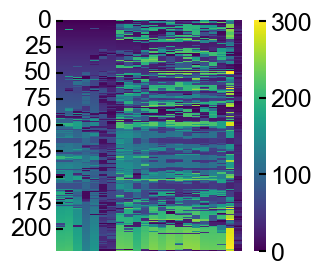

In [19]:
fig, ax = plt.subplots(figsize=(3,3))
aln_results.plot_position_heatmap(ax)
ax.xaxis.set_visible(False)

### `pairk.pairk_alignment_needleman` - faster

This method returns the same results as `pairk.pairk_alignment`, but it is faster.

The difference is that the `pairk.pairk_alignment_needleman` method uses the Needleman-Wunsch algorithm to align the k-mers, while the `pairk.pairk_alignment` method uses a scoring matrix to exhaustively score the k-mer matches. It ensures that the alignment is gapless by using an extremely high gap opening and extension penalty (-1000000). This will ensure that the alignment is gapless, unless you use a really unusual scoring matrix with very high scores.

This methods take similar arguments as `pairk.pairk_alignment`, accept that the `pairk.pairk_alignment_needleman` method takes an optional `aligner` argument. This allows you to create the aligner before calling the method, which is useful if you want to do multiprocessing, so that you're not creating a new aligner for each process. I've found that if you create a new aligner for each process, the memory usage gets very high, as if the memory isn't being released until the entire script finishes

The `aligner` object can be created via the `pairk.create_aligner` function. This function takes the name of the scoring matrix as an argument and returns the aligner object.
If you don't pass the `aligner` argument to the `pairk.pairk_alignment_needleman` method, it will create a new aligner using the `matrix_name` argument. This is fine if you're not doing multiprocessing. If you are doing multiprocessing, i would suggest creating the aligner before calling the method. Or using 1 aligner for each process. If the `aligner` argument is passed, the `matrix_name` argument is ignored.

In [20]:
# Making the aligner ahead of time to demonstrate
aligner = pairk.make_aligner('EDSSMat50')

In [21]:
aln_results_needleman = pairk.pairk_alignment_needleman(
    idr_dict_in=ex1.idr_dict, 
    query_id=ex1.query_id,
    k=5, 
    aligner=aligner
)

results are the same as the previous method

In [22]:
(aln_results.position_matrix == aln_results_needleman.position_matrix).all().all()

True

## ESM2 embedding distance method

### `pairk.pairk_alignment_embedding_distance`

This method uses the Euclidean distance between the query k-mer residue embeddings and homolog k-mer residue embeddings and selects the lowest distanc match from each homolog.<br>
For each homolog, it calculates the distance between the query k-mer and each k-mer in the homolog. It then selects the k-mer with the lowest distance as the best match.<br>

Because residue embeddings are used, the inputs are slightly different than the previous methods. The inputs are:<br>
- `full_length_dict_in` - a dictionary of full-length sequences, where the keys are the sequence ids and the values are the sequences. This is used to generate the embeddings.
- `idr_position_map` - a dictionary where the keys are the full-length sequence ids and the values are the start and end positions of the IDR in the full-length sequence (using python indexing). This is used slice out the IDR embeddings/sequences from the full length embeddings/sequences.
- `query_id` - a query sequence id (the sequence to split into k-mers and align with the homologs). This id should be present in `idr_position_map` and `full_length_dict_in`.
- `k` - the length of the k-mers
- `mod` - a `pairk.ESM_Model` object. This is the ESM2 model used to generate the embeddings. The code for the ESM2 embeddings is adapted from the kibby conservation tool [link](https://github.com/esbgkannan/kibby) DOI: 10.1093/bib/bbac599
- `device` - the "device" for pytorch to use to generate the embeddings, either "cpu" or "cuda". (default is "cuda"). If "cuda" fails, it will default to "cpu".

The `mod` input is required so that you can preload the ESM model before running the method. <br><br>
Full length sequences (`full_length_dict_in`) are required to generate the embeddings because each embedding is dependent upon the neighboring residues. The embeddings for just an IDR are different than the embeddings for a full length sequences. Thus, the full length embeddings are gathered first, and then the IDR embeddings are sliced out for the k-mer alignment. <br><br>The `idr_position_map` is used to slice out the IDR embeddings, and there must be IDR positions for each sequence in the input sequence set.

There is currently no way to use pre-generated embeddings for this method. I may add this in the future.

#### loading an ESM2 model using `pairk.ESM_Model`

In [23]:
pairk.ESM_Model?

Init signature: pairk.ESM_Model(model_name: str = 'esm2_t33_650M_UR50D', threads: int = 1)
Docstring:     
This was adapted from the kibby conservation method: DOI: 10.1093/bib/bbac599.
see https://github.com/esbgkannan/kibby

Class that loads a specified ESM model. Provides a method for encoding protein sequences.

available models:
- esm1b_t33_650M_UR50S
- esm2_t6_8M_UR50D
- esm2_t12_35M_UR50D
- esm2_t30_150M_UR50D
- esm2_t33_650M_UR50D (default)
- esm2_t36_3B_UR50D


Attributes
----------
model_name : str
    the name of the model that was loaded.
threads : int
    the number of threads for pytorch to use, by default 1.
File:           ~/Dropbox (MIT)/work/07-SLiM_bioinformatics/11-pairk/pairk/backend/tools/esm_tools.py
Type:           type
Subclasses:     

In [26]:
mod = pairk.ESM_Model(threads=4)

/Users/jackson/Dropbox (MIT)/work/07-SLiM_bioinformatics/11-pairk/pairk/backend/tools/esm_tools.py:30: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1716905753432/work/aten/src/ATen/ParallelNative.cpp:228.)
  torch.set_num_threads(threads)


Luckily, I already have a full length sequence dictionary and an IDR position map for the example sequences, so we can use those for this example

I will just use the cpu for this example, but you would set the device to "cuda" if you have cuda set up on your machine and want to use gpu

installation and set up of cuda is outside the scope of this documentation/tutorial

In [27]:
aln_results_embedding = pairk.pairk_alignment_embedding_distance(
    full_length_dict_in=ex1.full_length_dict,
    idr_position_map=ex1.idr_position_map,
    query_id=ex1.query_id,
    k=5,
    mod=mod,
    device='cpu',
)

# step 2. pairk_conservation

The last step is to calculate the conservation scores for the pseudo-MSAs. This is done via the `pairk.calculate_conservation` method. It simply takes the `PairkAln` object as input, along with a columnwise conservation scoring function and returns a `PairkConservation` object.

In [23]:
pairk.calculate_conservation?

Signature:
pairk.calculate_conservation(
    pairk_aln_results: pairk.backend.tools.pairwise_tools.PairkAln,
    score_func: Callable = <function property_entropy at 0x12f9f84a0>,
) -> pairk.backend.conservation.kmer_conservation.PairkConservation
Docstring:
calculate the conservation scores for the k-mers in the PairkAln object. calculates the conservation scores and z-scores for each k-mer position.

Parameters
----------
pairk_aln_results : PairkAln
    the results of the pairk alignment step as a pairk.PairkAln object.
score_func : Callable, optional
    A function to calculate conservation scores in a columnwise manner, by
    default it is the property_entropy function from Capra and Singh 2007,
    DOI: 10.1093/bioinformatics/btm270 located in the
    `pairk.pairk_conservation.capra_singh_functions` module.

Returns
-------
PairkConservation
    PairkConservation object containing the conservation scores and z-scores for each k-mer position.
File:      ~/Dropbox (MIT)/work/07-SL

In [25]:
conservation_results = pairk.calculate_conservation(aln_results_needleman)
print(conservation_results)

PairkConservation object
222 query kmers x 23 orthologs
kmer length - 5
1110 background scores for z-score calculation
222 kmers used for z-score calculation


Any function that takes a string of residues representing a column of a sequence alignment can be used to calculate the conservation scores. <br>By default the property_entropy function from Capra and Singh 2007 (DOI: 10.1093/bioinformatics/btm270) is used.<br>A shannon entropy function is also available in the `pairk.pairk_conservation.capra_singh_functions` module.

In [26]:
from pairk.pairk_conservation import capra_singh_functions
capra_singh_functions?

Type:        module
String form: <module 'pairk.backend.conservation.capra_singh_functions' from '/Users/jackson/Dropbox (MIT)/work/07-SLiM_bioinformatics/11-pairk/pairk/backend/conservation/capra_singh_functions/__init__.py'>
File:        ~/Dropbox (MIT)/work/07-SLiM_bioinformatics/11-pairk/pairk/backend/conservation/capra_singh_functions/__init__.py
Docstring:  
Module to hold conservation methods from Capra and Singh 2007, DOI: 10.1093/bioinformatics/btm270

The methods in this module are used to calculate column-wise conservation scores and take a string of characters (an alignment column) as input.
Conservation scores are calculated and normalized to a range of 0 to 1, where 0 is the least conserved and 1 is the most conserved.
By default, gaps are penalized by multiplying the final conservation score by the fraction of non-gap characters in the column.

Methods:
--------
property_entropy : Callable
    Calculate the property entropy of a column of sequence characters
shannon_entr

Example conservation scoring function

In [27]:
column = 'NNNNNNNNNKNSNNNNNNNNSSN'
print(capra_singh_functions.shannon_entropy(column))

0.8161170118989496


In [29]:
conservation_results = pairk.calculate_conservation(
    pairk_aln_results=aln_results_needleman,
    score_func=capra_singh_functions.shannon_entropy
)
print(conservation_results)

PairkConservation object
222 query kmers x 23 orthologs
kmer length - 5
1110 background scores for z-score calculation
222 kmers used for z-score calculation


In [ ]:
query_aln_str = str([i for i in list(ex1.alignment) if i.id == ex1.query_id][0].seq)

In [ ]:
pairk.pairk_alignment_embedding_distance?

Signature:
pairk.pairk_alignment_embedding_distance(
    full_length_dict_in: dict,
    idr_position_map: dict[str, list[int]],
    query_id: str,
    k: int,
    mod: pairk.backend.tools.esm_tools.ESM_Model,
    **kwargs,
)
Docstring: <no docstring>
File:      ~/Dropbox (MIT)/work/07-SLiM_bioinformatics/11-pairk/pairk/backend/kmer_alignment/esm_embedding_distance.py
Type:      function

In [ ]:
pairk.ESM_Model

In [ ]:
import pairk.backend.tools.sequence_utils as tools

In [ ]:
t = '--LPPPP---PP------TEST--'
tun, ind = tools.reindex_alignment_str(t)

In [ ]:
tun, ind = tools.aligned_2_unaligned_index(t)


''

In [ ]:
for c, a in enumerate(t):
    print(c, a)

0 -
1 -
2 L
3 P
4 P
5 P
6 P
7 -
8 -
9 -
10 P
11 P
12 -
13 -
14 -
15 -
16 -
17 -
18 T
19 E
20 S
21 T
22 -
23 -


In [ ]:
for i, ti in zip(ind, t):
    print(i, ti)

None -
None -
0 L
1 P
2 P
3 P
4 P
4 -
4 -
4 -
5 P
6 P
6 -
6 -
6 -
6 -
6 -
6 -
7 T
8 E
9 S
10 T
10 -
10 -


In [ ]:
t = 'A--A--A'
tun, ind = tools.reindex_alignment_str(t)
t[ind[0]:ind[-1]+1]

'A--A--A'

In [ ]:
def find_alnslice_positions_in_unaln(aln, aln_start, aln_end):
    positions = []
    unaln_index = 0
    for i in range(len(aln)):
        if aln[i] != '-':
            if aln_start <= i < aln_end:
                positions.append(unaln_index)
            unaln_index += 1
    return positions

In [ ]:
t = '--LPPPP---PP------TEST--'
tun = tools.strip_dashes_from_str(t)
start = 6
end = 13
print(t[start:end])
unal_pos =find_alnslice_positions_in_unaln(t, start, end)
print(unal_pos)
if len(unal_pos) == 0:
    print('No positions')
else:
    print(tun[unal_pos[0]:unal_pos[-1]+1])
for i in unal_pos:
    print(i, tun[i])

P---PP-
[4, 5, 6]
PPP
4 P
5 P
6 P


In [ ]:
ind
# len(t)

[2, 3, 4, 5, 6, 10, 11, 18, 19, 20, 21]

In [ ]:
import pairk.single_kmer as pairk_single
pairk_single.pairk_alignment_single_kmer("LPPPP", idr_dict)

ValueError: Multiple best scores found

In [ ]:

import pairk
ex1 = pairk.example1
aln_results = pairk.pairk_alignment(
    idr_dict_in=ex1.idr_dict, 
    query_id=ex1.query_id,
    k=5, 
    matrix_name="EDSSMat50"
)

pairkcons = calculate_pairk_conservation(aln_results, cs.property_entropy)



In [ ]:
import pairk
ex1 = pairk.example1
aln_results = pairk.pairk_alignment(
    idr_dict_in=ex1.idr_dict, 
    query_id=ex1.query_id,
    k=5, 
    matrix_name="EDSSMat50"
)

ok_arr, score_arr, z_score_arr = calculate_conservation(aln_results.orthokmer_matrix, cs.property_entropy)
pairk_conservation = PairkConservation(ok_arr, score_arr, z_score_arr)

In [ ]:
pairk_conservation.plot_background_distribution()
plt.show()

In [ ]:
pairk_conservation.print_array_hist(pairk_conservation.score_arr, np.linspace(0, 1, 30))
pairk_conservation.print_array_hist(pairk_conservation.z_score_arr, 30)

In [ ]:
pairk_conservation.write_results_to_file("test.npz")
pkc = PairkConservation.read_results_from_file("test.npz")

In [ ]:
print_array_hist(scores, np.linspace(0, 1, 30))
print_array_hist(z_scores, 30)

# Archive

In [ ]:

import pairk.backend.kmer_conservation.conservation_tools.capra_singh_2007_scores as cs
import pandas as pd
from typing import Callable
import numpy as np

In [ ]:

aln_results.orthokmer_matrix
# check that all elements in the orthokmer_matrix are strings

if not all([type(i) == str for i in aln_results.orthokmer_matrix.values.flatten()]):
    raise ValueError("Orthokmer matrix contains non-string elements")

# I think that numpy will be faster and it's pretty straightforward in this case.
orthokmer_arr = aln_results.orthokmer_matrix.values
orthokmer_arr[0, :]

In [ ]:
def kmerlist_to_columns(seqlist: np.ndarray):
    col_strings = []
    for c in range(len(seqlist[0])):
        col = "".join([seqlist[i][c] for i in range(len(seqlist))])
        col_strings.append(col)
    return col_strings

kmerlist_to_columns(orthokmer_arr[0, :])

In [ ]:
def score_pseudo_aln(
    seqlist: np.ndarray,
    score_func: Callable = cs.property_entropy,
):
    col_strings = kmerlist_to_columns(seqlist)
    return [score_func(c) for c in col_strings]

score_pseudo_aln(orthokmer_arr[0, :])

In [ ]:

def orthokmer_df_to_score_arr(orthokmer_df: pd.DataFrame, score_func: Callable) -> np.ndarray:
    orthokmer_arr = orthokmer_df.copy().values
    k = len(orthokmer_arr[0,0])
    score_arr = np.zeros((orthokmer_arr.shape[0], k))
    for i in range(orthokmer_arr.shape[0]):
        score_arr[i, :] = score_pseudo_alns(orthokmer_arr[i, :])
    return score_arr

score_arr = orthokmer_df_to_score_arr(aln_results.orthokmer_matrix, cs.property_entropy)
bg_scores = score_arr.flatten()
n_bg_scores = len(bg_scores)
u = bg_scores.mean()
s = bg_scores.std()
z_score_arr = (score_arr - u) / s

In [ ]:
# print a text representation of a histogram of the z-scores
def print_array_hist(a: np.ndarray, bins=30):
    hist, bin_edges = np.histogram(a.flatten(), bins=bins)
    for i, h in enumerate(hist):
        print(f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}: {'=' * h}")

print_array_hist(score_arr, np.linspace(0, 1, 30))
print_array_hist(score_arr, 10)




In [ ]:

# convert the score matrix to a z-score matrix
def score_to_zscore(score_arr: np.ndarray, bg_scores: np.ndarray) -> np.ndarray:
    zscore_arr = np.zeros(score_arr.shape)
    for i in range(score_arr.shape[0]):
        zscore_arr[i, :] = (score_arr[i, :] - bg_scores.mean()) / bg_scores.std()
    return zscore_arr





















